## Selecionando Features importântes

### Métodos:
- Recursive feature elimination
- Correlação
- Seleção baseada em clustering

In [6]:
#Bibliotecas e modulos
import sys
sys.path.append('thyroid_disease_AI')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE #para o balanceamento de dados
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from utils import *

In [7]:
#Carregando dataset
dataset = pd.read_csv('/content/hypothyroid.csv')

#transformando os dados em dados categoricos
for index in dataset.columns.values:
        dataset[index]= dataset[index].astype("category").cat.codes.values

#Processo de limpeza do dataset(removendo linhas com dados faltantes)
for i in dataset.columns.values:
    dataset.drop(dataset[dataset[i] == '?'].index, inplace=True)
dataset = dataset.drop('TBG', axis=1)

In [8]:
#dividindo o dataset
output_label_dataset = dataset['binaryClass']
#dados que serão introduzidos no modelo
dataset = dataset.drop(['binaryClass'], axis=1)


In [9]:
#Balanceando dos dados
dataset_res, ouput_label = balance_dataset_smote(dataset, output_label_dataset, random_state=42, k_neighbors=5)

#Dividindo o dataset em treino e teste
#80 % para treino e 20% para teste
input_train, input_test, output_train, output_test = slipt_and_standardize_dataset(dataset=dataset_res, output_label=ouput_label)

### Recursive Feature Elimination (RFE)

- O método RFE (Recursive Feature Elimination) é uma técnica de seleção de recursos (features) que visa identificar um subconjunto relevante de características em um conjunto de dados. Ele utiliza um algoritmo de aprendizado de máquina para estimar a importância de cada característica e, em seguida, elimina recursivamente as menos importantes.

In [10]:
#Treinando o modelo com todas as features
model = RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, min_samples_leaf=5, n_estimators=10,
                       random_state=10)
model.fit(dataset, output_label_dataset)

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, min_samples_leaf=5, n_estimators=10,
                       random_state=10)

In [12]:
#Selecionando as variáveis mais importantes

#Criando um objeto RFE (Recursive Feature Elimination) com o modelo e os parâmetros desejados, selecionando 10 features
selector = RFE(model, n_features_to_select=3, step=1)
#Ajustando o seletor de recursos ao conjunto de dados e aos rótulos de saída
selector = selector.fit(dataset, output_label_dataset)
#Selecionando as características escolhidas pelo seletor de recursos e armazenando seus nomes em uma lista
selected_features = dataset.columns[selector.support_]
#Mostrando features selecionadas
print('Features selecionadas: \n', selected_features)

Features selecionadas: 
 Index(['TSH', 'T3', 'FTI'], dtype='object')


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(



A acurácia é de:  0.9483129935391242


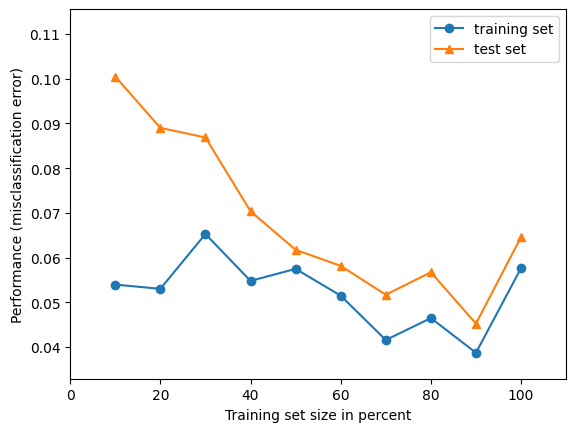

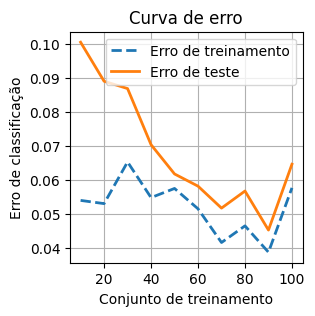

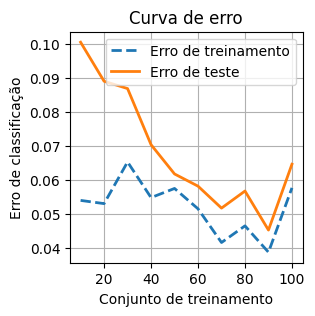

In [ ]:
# Selecionar os recursos do conjunto de treinamento e teste
input_train_seletor = selector.transform(input_train)
X_test_seletor = selector.transform(input_test)

# Criando um novo modelo com os recursos selecionados
model.fit(input_train_seletor, output_train)

# Avaliando a acuracia do modelo no conjunto de teste
y_pred = model.predict(X_test_seletor)
accuracy(output_test, y_pred)
miss_classification(input_train, output_train, input_test, output_test, model)

### Resultados:

- 2 features ['TSH', 'FTI']

- 3 features ['TSH', 'T3', 'FTI']

- 5 features ['TSH measured', 'TSH', 'T3', 'TT4', 'FTI']

- 8 features ['age', 'TSH measured', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'referral source']

- 10 features ['age', 'sex', 'on thyroxine', 'TSH measured', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'referral source']

- 12 features ['age', 'sex', 'on thyroxine', 'query hypothyroid', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4', 'T4U', 'FTI', 'referral source']

### Correlação

- A correlação mede a relação estatística entre duas variáveis e é calculada usando uma métrica chamada coeficiente de correlação. A ideia básica do método de correlação para seleção de features é avaliar a correlação entre cada feature e a variável de destino (rótulo ou saída desejada). A intuição por trás desse método é que features altamente correlacionadas com a variável de destino podem ter um impacto significativo na capacidade de previsão do modelo.

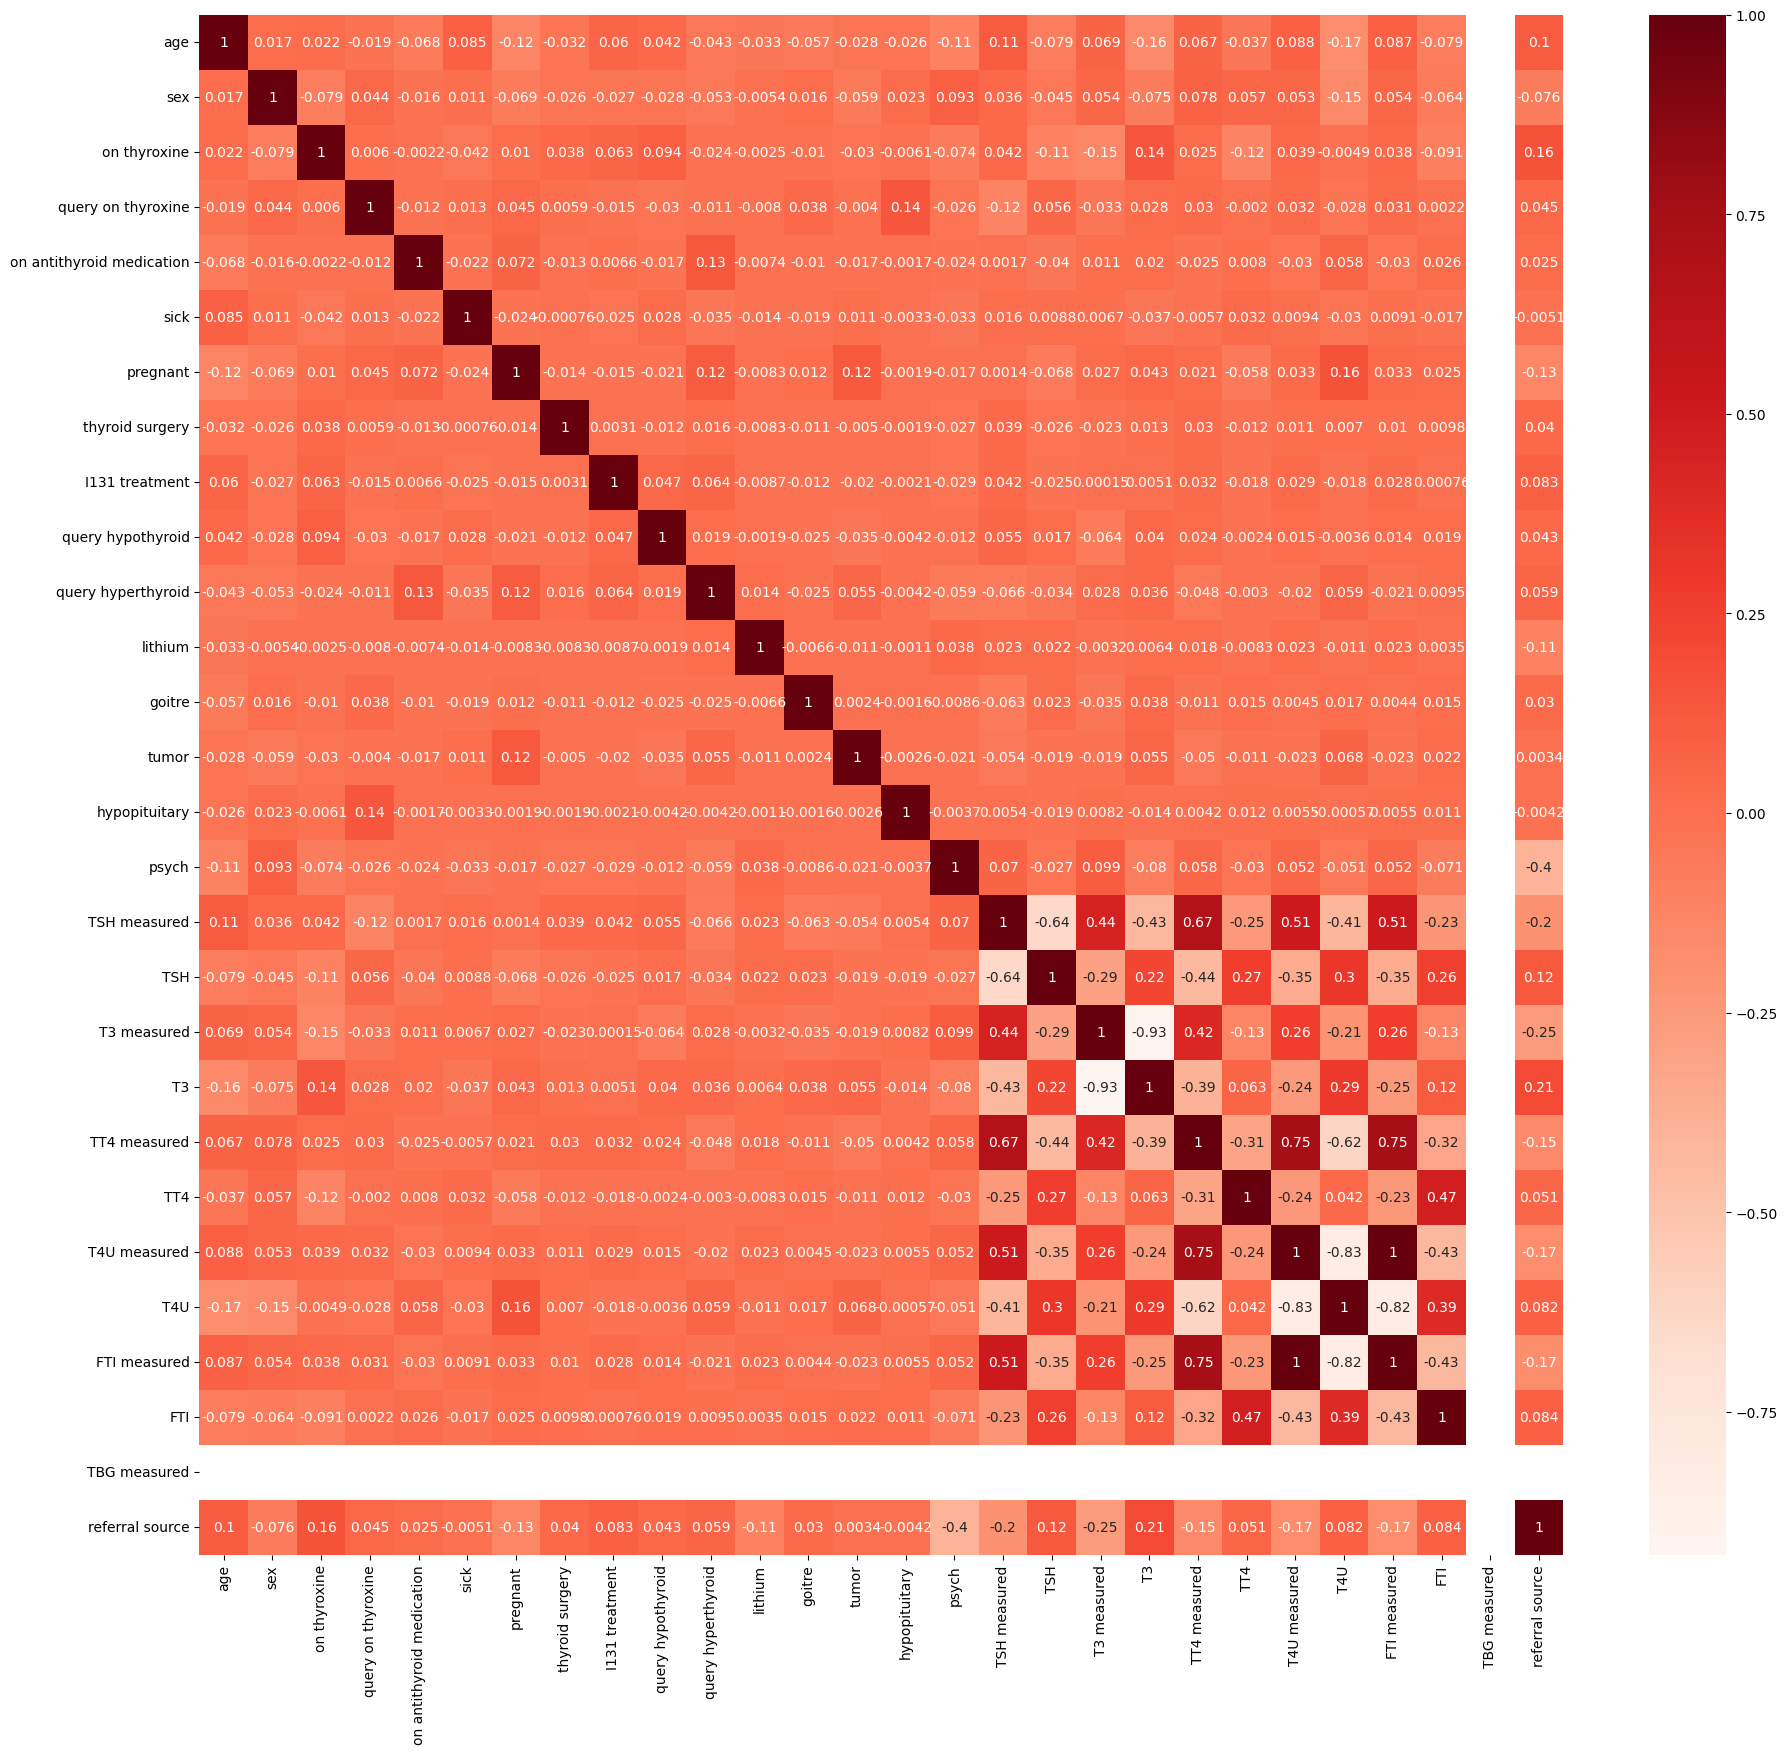

Melhores features:
Feature: ('T4U measured', 'FTI measured') | Correlação: 0.9971181474257158
Feature: ('FTI measured', 'T4U measured') | Correlação: 0.9971181474257158
Feature: ('T3 measured', 'T3') | Correlação: 0.9289411756861745
Feature: ('T3', 'T3 measured') | Correlação: 0.9289411756861745
Feature: ('T4U measured', 'T4U') | Correlação: 0.8260166917975377
Feature: ('T4U', 'T4U measured') | Correlação: 0.8260166917975377
Feature: ('T4U', 'FTI measured') | Correlação: 0.8236362334678783
Feature: ('FTI measured', 'T4U') | Correlação: 0.8236362334678783
Feature: ('TT4 measured', 'T4U measured') | Correlação: 0.7480946081447832
Feature: ('T4U measured', 'TT4 measured') | Correlação: 0.7480946081447832
Feature: ('TT4 measured', 'FTI measured') | Correlação: 0.7466087673939504
Feature: ('FTI measured', 'TT4 measured') | Correlação: 0.7466087673939504
Feature: ('TSH measured', 'TT4 measured') | Correlação: 0.6714293782020254
Feature: ('TT4 measured', 'TSH measured') | Correlação: 0.671429

In [ ]:
plt.figure(figsize=(22,20))
cor = dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.savefig('correlação.png', dpi=300, bbox_inches='tight')
plt.show()

num_features = 24

# Obtendo as melhores features com correlação mais próxima de 1
best_features = cor.unstack().abs()
best_features = best_features[(best_features < 1)].nlargest(num_features)

# Imprimindo as melhores features
print("Melhores features:")
for feature, correlation in best_features.items():
    print(f"Feature: {feature} | Correlação: {correlation}")

### Resultados

- 10 Features selecionadas: ['T4U', 'T4U measured', 'FTI', 'FTI measured', 'T3', 'T3 measured', 'TT4', 'TT4 measured', 'TSH', 'TSH measured']

### Seleção baseada em clustering

- É uma técnica usada para identificar um subconjunto relevante de features em conjuntos de dados. Essa abordagem utiliza algoritmos de clustering para agrupar as instâncias de dados com base em suas características, e depois analisa a distribuição das features em cada cluster para selecionar as mais discriminativas.

In [13]:
# Criando clusters usando KMeans
list_num_clusters = [3, 5, 8, 10, 12]
for num_clusters in list_num_clusters:
    kmeans = KMeans(n_clusters = num_clusters, random_state = 42)
    kmeans.fit(input_train)
    print(f'{num_clusters} Clusters: ')

    # Selecionando recursos importantes usando LassoCV
    list_num_features = [2, 3, 5, 8, 10, 12]
    for num_features in list_num_features:
        lasso = LassoCV(cv=5)
        selection = SelectFromModel(estimator=lasso, threshold=-np.inf, max_features = num_features)
        selection.fit(input_train, kmeans.labels_)
        selected_features = selection.get_support(indices=True)

        print(f'{num_features} Features selecionadas:')
        for feature_index in selected_features:
            print(dataset.columns[feature_index])
        print()

# Imprimindo os recursos selecionados
# print("Recursos selecionados: ", dataset.columns[selected_features])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3 Clusters: 
2 Features selecionadas:
TT4
T4U measured

3 Features selecionadas:
TT4
T4U measured
FTI measured

5 Features selecionadas:
T3
TT4
T4U measured
FTI measured
FTI

8 Features selecionadas:
TSH
T3
TT4 measured
TT4
T4U measured
T4U
FTI measured
FTI

10 Features selecionadas:
on thyroxine
TSH
T3 measured
T3
TT4 measured
TT4
T4U measured
T4U
FTI measured
FTI

12 Features selecionadas:
on thyroxine
query hyperthyroid
psych
TSH
T3 measured
T3
TT4 measured
TT4
T4U measured
T4U
FTI measured
FTI



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5 Clusters: 
2 Features selecionadas:
T3 measured
TT4 measured

3 Features selecionadas:
T3 measured
TT4 measured
TT4

5 Features selecionadas:
pregnant
psych
T3 measured
TT4 measured
TT4

8 Features selecionadas:
pregnant
psych
T3 measured
T3
TT4 measured
TT4
T4U
FTI

10 Features selecionadas:
pregnant
psych
TSH measured
TSH
T3 measured
T3
TT4 measured
TT4
T4U
FTI

12 Features selecionadas:
pregnant
query hyperthyroid
lithium
psych
TSH measured
TSH
T3 measured
T3
TT4 measured
TT4
T4U
FTI



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8 Clusters: 
2 Features selecionadas:
T3 measured
T4U measured

3 Features selecionadas:
T3 measured
TT4
T4U measured

5 Features selecionadas:
I131 treatment
T3 measured
TT4
T4U measured
FTI

8 Features selecionadas:
I131 treatment
psych
TSH
T3 measured
T3
TT4
T4U measured
FTI

10 Features selecionadas:
I131 treatment
psych
TSH
T3 measured
T3
TT4
T4U measured
T4U
FTI measured
FTI

12 Features selecionadas:
I131 treatment
query hyperthyroid
psych
TSH
T3 measured
T3
TT4 measured
TT4
T4U measured
T4U
FTI measured
FTI



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10 Clusters: 
2 Features selecionadas:
TT4 measured
T4U measured

3 Features selecionadas:
pregnant
TT4 measured
T4U measured

5 Features selecionadas:
sick
pregnant
T3 measured
TT4 measured
T4U measured

8 Features selecionadas:
sick
pregnant
lithium
T3 measured
TT4 measured
TT4
T4U measured
FTI

10 Features selecionadas:
sick
pregnant
I131 treatment
lithium
T3 measured
T3
TT4 measured
TT4
T4U measured
FTI

12 Features selecionadas:
sick
pregnant
I131 treatment
lithium
TSH measured
TSH
T3 measured
T3
TT4 measured
TT4
T4U measured
FTI



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


12 Clusters: 
2 Features selecionadas:
TT4 measured
T4U measured

3 Features selecionadas:
sick
TT4 measured
T4U measured

5 Features selecionadas:
sick
I131 treatment
T3 measured
TT4 measured
T4U measured

8 Features selecionadas:
on antithyroid medication
sick
I131 treatment
lithium
T3 measured
TT4 measured
TT4
T4U measured

10 Features selecionadas:
on antithyroid medication
sick
I131 treatment
lithium
goitre
psych
T3 measured
TT4 measured
TT4
T4U measured

12 Features selecionadas:
on antithyroid medication
sick
pregnant
I131 treatment
lithium
goitre
psych
T3 measured
TT4 measured
TT4
T4U measured
FTI



### Resultados:

#### 3 clusters
- 2 features ['TT4', 'T4U measured']
- 3 features ['TT4', 'T4U measured', 'FTI measured']
- 5 features ['T3', 'TT4', 'T4U measured', 'FTI measured', 'FTI']
- 8 features ['TSH', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI']
- 10 features ['on thyroxine', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI']
- 12 features ['on thyroxine', 'query hyperthyroid', 'psych', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI']

#### 5 clusters
- 2 features ['T3 measured', 'TT4 measured']
- 3 features ['T3 measured', 'TT4 measured', 'TT4']
- 5 features ['pregnant', 'psych', 'T3 measured', 'TT4 measured', 'TT4']
- 8 features ['pregnant', 'psych', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U', 'FTI']
- 10 features ['pregnant', 'psych', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured, 'TT4', 'T4U', 'FTI']
- 12 features ['pregnant', 'query hyperthyroid', 'lithium', 'psych', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U', 'FTI']

#### 8 clusters
- 2 features ['T3 measured', 'TT4 measured']
- 3 features ['T3 measured', 'TT4', 'T4U measured']
- 5 features ['I131 treatment', 'T3 measured', 'TT4', 'T4U measured', 'FTI']
- 8 features ['I131 treatment', 'psych', 'TSH', 'T3 measured', 'T3', 'TT4', 'T4U measured', 'FTI']
- 10 features ['I131 treatment', 'psych', 'TSH', 'T3 measured', 'T3', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI']
- 12 features ['I131 treatment', 'query hyperthyroid', 'psych', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI']

#### 10 clusters
- 2 features ['TT4 measured', 'T4U measured']
- 3 features ['pregnant', 'TT4 measured', 'T4U measured']
- 5 features ['sick', 'pregnant', 'T3 measured', 'TT4 measured', 'T4U measured']
- 8 features ['sick', 'pregnant', 'lithium', 'T3 measured', 'TT4 measured', 'TT4', 'T4U measured', 'FTI']
- 10 features ['sick', 'pregnant', 'I131 treatment', 'lithium', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'FTI']
- 12 features ['sick', 'pregnant', 'I131 treatment', 'lithium', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'FTI']

#### 12 clusters
- 2 features ['TT4 measured', 'T4U measured']
- 3 features ['sick', 'TT4 measured', 'T4U measured']
- 5 features ['sick', 'I131 treatment', 'T3 measured', 'TT4 measured', 'T4U measured']
- 8 features ['on antithyroid medication', 'sick', 'I131 treatment', 'lithium', 'T3 measured', 'TT4 measured', 'TT4', 'T4U measured']
- 10 features ['on antithyroid medication', 'sick', 'I131 treatment', 'lithium', 'goitre', 'psych', 'T3 measured', 'TT4 measured', 'TT4', 'T4U measured']
- 12 features ['on antithyroid medication', 'sick', 'pregnant', 'I131 treatment', 'lithium', 'goitre', 'psych', 'T3 measured', 'TT4 measured', 'TT4', 'T4U measured', 'FTI']